In [1]:
import numpy as np
import gym
import math
import random
from collections import namedtuple
from itertools import count
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

%matplotlib inline

In [2]:
env = gym.make('CarRacing-v0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper parameters

In [3]:
HIDDEN_LAYER = 128

# Encoder

In [4]:
def conv_size(size, kernel_size, stride, padding):
    return (size - (kernel_size - 1) - 1 + padding) // stride + 1

class ConvEncoder(nn.Module):
    def __init__(self, h, w, hidden_layer):
        super(ConvEncoder, self).__init__()  
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=2, padding=1)
        
        self.conv_h = conv_size(conv_size(h, 5, 2, 1), 5, 2, 1)
        self.conv_w = conv_size(conv_size(w, 5, 2, 1), 5, 2, 1)     
        self.after_sz = self.conv_h * self.conv_w * 16
        
        self.encode = nn.Linear(self.after_sz, hidden_layer)
        self.decode = nn.Linear(hidden_layer, self.after_sz)
  
        self.deconv1 = nn.ConvTranspose2d(16, 6, kernel_size=5, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(6, 3, kernel_size=5, stride=2, padding=1, output_padding=1)
        
        self.finish = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        return x
    

class SimpleEncoder(nn.Module):
    def __init__(self, h, w, hidden_layer):
        super(SimpleEncoder, self).__init__()

        self.w = w
        self.h = h
        self.sz = h * w * 3
        self.encode = nn.Linear(self.sz, hidden_layer)
        self.mid = nn.Sigmoid()
        self.decode = nn.Linear(hidden_layer, self.sz)

    def forward(self, x):
        x = x.reshape(-1, self.sz) 
        x = self.encode(x)
        x = self.mid(x)
        x = self.decode(x)
        x = x.view(-1, 3, self.w, self.h)
        return x

# Declare model

In [5]:
H, W, _ = env.observation_space.shape

encoder = ConvEncoder(H, W, HIDDEN_LAYER).to(device)
optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
distance = nn.MSELoss()

# Training loop 

Track generation: 1118..1407 -> 289-tiles track


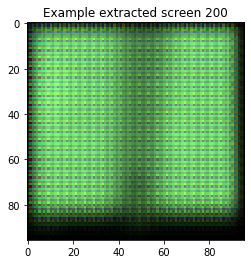

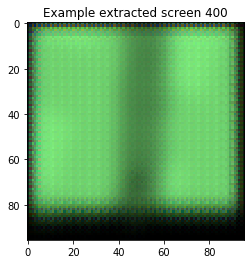

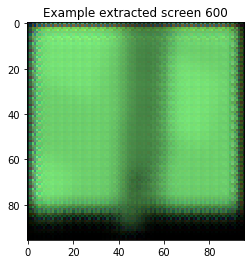

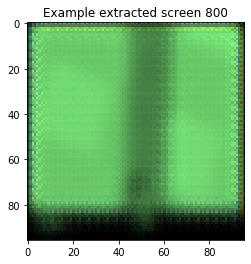

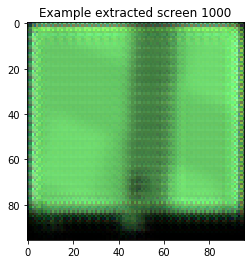

Track generation: 1171..1468 -> 297-tiles track


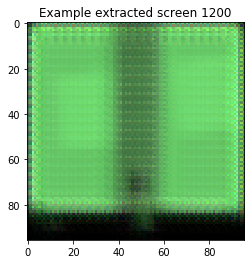

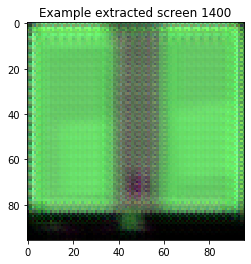

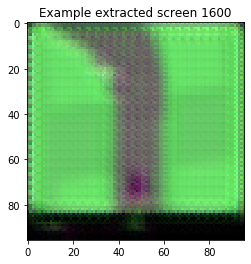

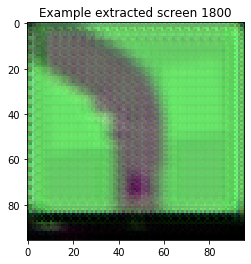

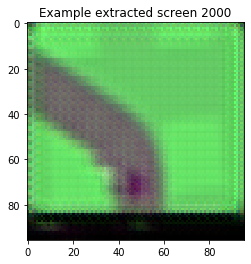

Track generation: 1160..1458 -> 298-tiles track


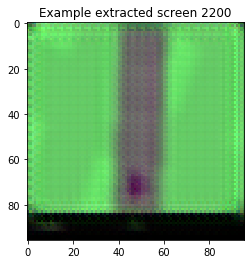

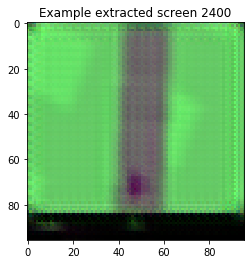

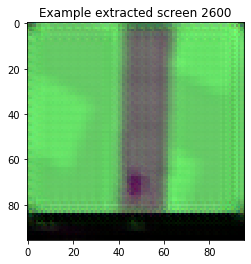

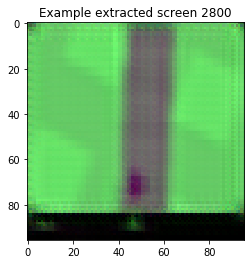

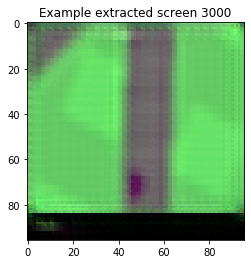

Track generation: 1223..1543 -> 320-tiles track


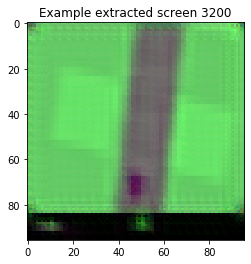

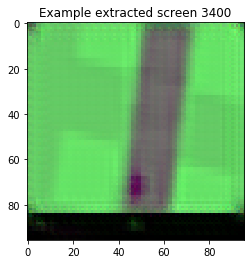

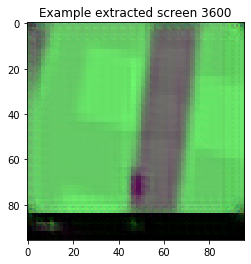

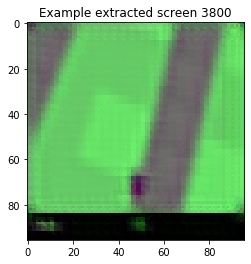

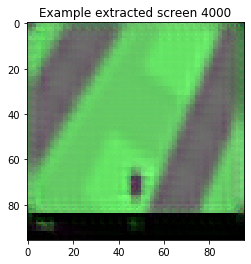

Track generation: 1193..1495 -> 302-tiles track


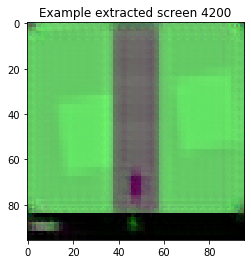

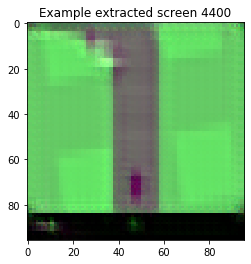

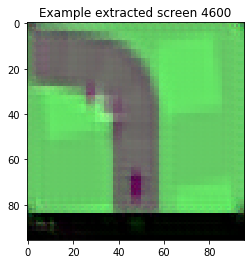

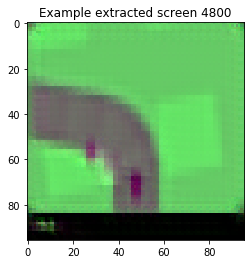

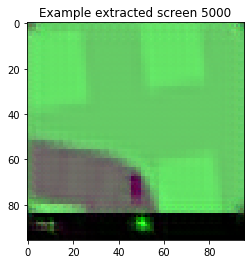

Track generation: 1053..1328 -> 275-tiles track


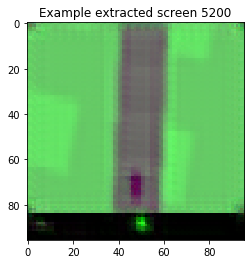

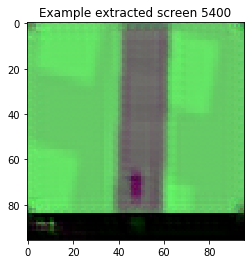

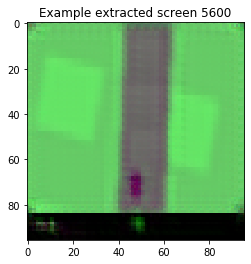

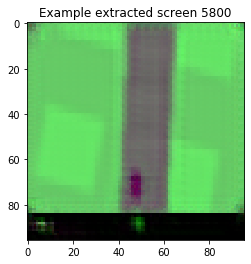

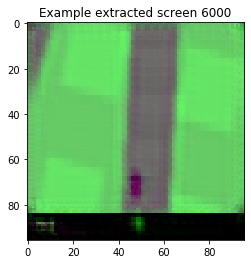

Track generation: 1216..1524 -> 308-tiles track


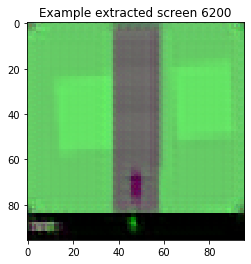

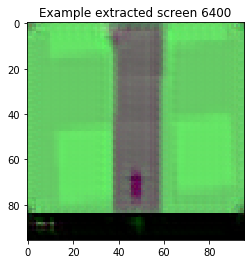

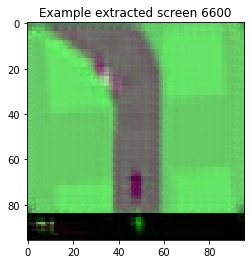

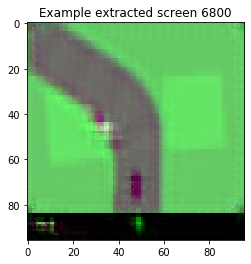

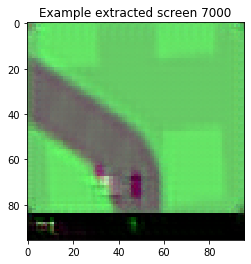

Track generation: 1023..1291 -> 268-tiles track


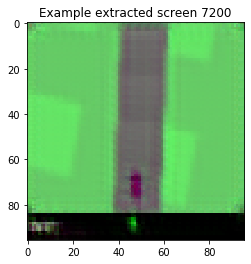

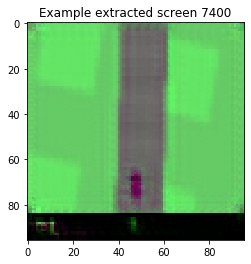

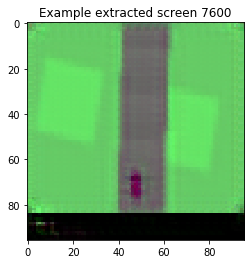

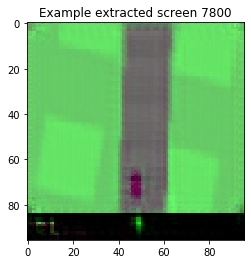

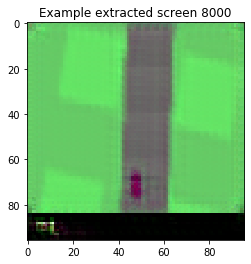

Track generation: 1211..1516 -> 305-tiles track


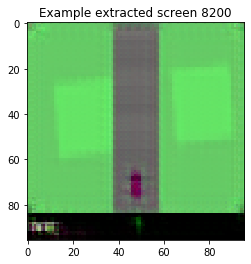

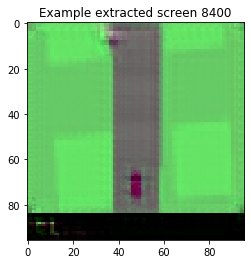

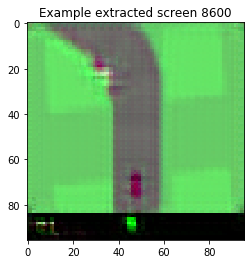

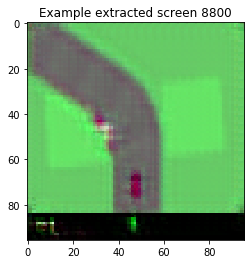

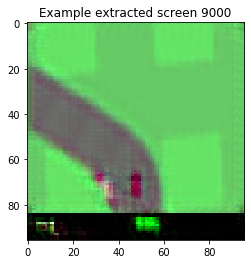

Track generation: 1087..1363 -> 276-tiles track


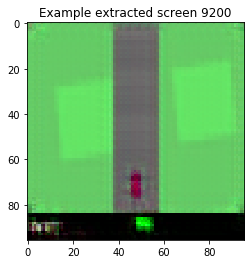

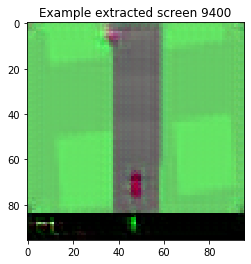

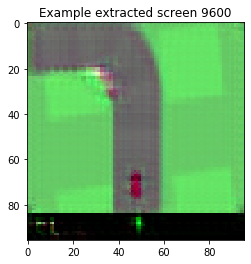

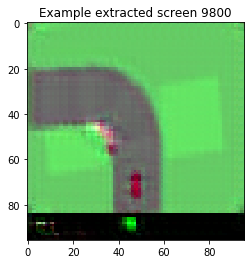

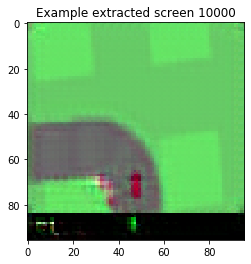

In [6]:
steps = 0
episodes = 10

for now in range(episodes):
    state = torch.tensor([env.reset()], dtype=torch.float32, device=device).permute(0, 3, 1, 2)
    done = False
    while not done:
        steps += 1
        action = env.action_space.sample()
        state, _, done, _ = env.step(action)

        state = torch.tensor([state], dtype=torch.float32, device=device).permute(0, 3, 1, 2)
        funny_state = state
        funny_state = encoder(funny_state)

        loss = distance(state, funny_state)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % 200 == 0:
            plt.imshow(funny_state.cpu().detach().clamp(0, 256).squeeze(0).permute(1, 2, 0).numpy() / 256,interpolation='none')
            plt.title('Example extracted screen {}'.format(steps))
            plt.show()

    env.close()